In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from SpectralCorr import *

### 1. Generate AR1 timeseries. These are randomly generated and so they shouldn't be significantly correlated

In [2]:
N = 500               # number of time points
dt = 1.0              # time step = 1 month
fs = 1 / dt           # sampling frequenct = 1 / 1 month

# AR(1) parameters
rho_x = 0.9
rho_y = 0.9
noise_std = 1.0

# Preallocate arrays
ts1 = AR1_process(rho_x, noise_std, 1, N, seed = 42, dt = dt)
ts2 = AR1_process(rho_y, noise_std, 1, N, seed = 31, dt = dt)

ccf_maxlag = 36
ccf_ds = cross_correlation(ts1, ts2, maxlags=ccf_maxlag)
lag_max, ccf_max = cross_correlation_maxima(ts1, ts2, maxlags=ccf_maxlag)

/var/folders/xc/1pgd3mgn7qjdv8bmcggt31j40000gn/T/ipykernel_36001/4099375387.py:16: DeprecationWarning: cross_correlation_maxima() is deprecated and will be removed in a future version. Use maximum_cross_correlation() instead.
  lag_max, ccf_max = cross_correlation_maxima(ts1, ts2, maxlags=ccf_maxlag)


### 2. Visualize the lagged AR(1) time series

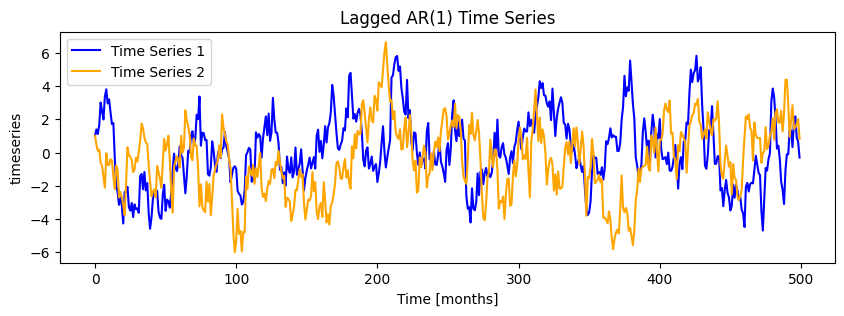

In [3]:
fig, axes = plt.subplots(figsize=(10, 3))
ts1.plot(ax = axes, label='Time Series 1', color='blue')
ts2.plot(ax = axes, label='Time Series 2', color='orange')
axes.set_title('Lagged AR(1) Time Series')
axes.set_xlabel('Time [months]')
axes.legend()

### 3. Visualize and check correlation significance using Pearson and Ebisuzaki methods

In [4]:
def plot_significant_correlations(ax, lags, ccf, pvals, alpha=0.05):
    """
    Scatter plot of cross-correlation coefficients, coloring points red if
    their p-value is below `alpha` and black otherwise.

    """
    sig_mask = pvals < alpha
    nonsig_mask = ~sig_mask

    ax.plot(lags, ccf, c="k", zorder=0)
    # Plot non-significant points
    ax.scatter(lags[nonsig_mask], ccf[nonsig_mask], c='k', marker='o', label='Not Significant', zorder=2)
    # Plot significant points
    ax.scatter(lags[sig_mask], ccf[sig_mask], c='r', marker='o', label='Significant', zorder=3)
    
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')

    return ax

def plot_conf_intervals(ax, lags, ccf_ensemble, alpha=0.05):
    limits = str(round(100 * (1 - alpha)))
    lb = ccf_ensemble.quantile(dim = "bootstrap_iter", q = 0.025)
    ub = ccf_ensemble.quantile(dim = "bootstrap_iter", q = 0.975)
    axes[1].fill_between(lags, lb, ub, alpha = 0.45, label = f"Bootstrapped {limits}% Confidence Limits")

    return ax

In [ ]:
alpha = 0.05 #signifance level 

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey = True)

fig.suptitle(f'Cross Correlation Significance using different methods (alpha={alpha})')

#### GAUSSIAN CCF SIGNIFICANCE #####
axes[0].set_title("Pearson Correlation Test")
ccf_ds = cross_correlation(ts1, ts2, maxlags=ccf_maxlag, method='pearson')
plot_significant_correlations(axes[0], ccf_ds["lag"], ccf_ds["cross_correlation"], ccf_ds["cross_correlation_pvalue"], alpha=alpha)

#### BOOTSTRAPPED (MONTE CARLO) CCF SIGNIFICANCE #####
axes[1].set_title("Ebisuzaki Correlation Test")
n_iter = 1000 #number of Monte Carlo Iterations 
bccf_ds = cross_correlation(ts1, ts2, maxlags=ccf_maxlag, method='ebisuzaki',
                           n_iter = n_iter, return_distributions = True, detrend = True)
plot_significant_correlations(axes[1], bccf_ds["lag"], bccf_ds["cross_correlation"], bccf_ds["cross_correlation_pvalue"], alpha=alpha)
plot_conf_intervals(axes[1], bccf_ds["lag"], bccf_ds["cross_correlation_distribution"], alpha=alpha)

axes[1].set_ylabel("")

for a in axes:
    a.legend(loc = "lower left")
    a.grid(zorder = 0, alpha = 0.1, c = "k")
fig.tight_layout()

Computing cross-correlation:  63%|██████▎   | 46/73 [00:05<00:03,  7.50it/s]